# Beijing Air Quality Forecasting Starter Notebook

In [143]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf

In [144]:
# Load datasets
import pandas as pd

train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")

# Explore the training data

In this sections explore your dataset with appropiate statistics and visualisations to understand your better.

In [145]:
# Inspecting the first few rows of the dataset to understand its structure.
print("Training Data Overview:")
train.head()

Training Data Overview:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN


This prints the first 5 rows of the training set. It helps confirm the column names, data types, and whether values look consistent. 
We can see the target column pm2.5, and features like TEMP, PRES, Iws (wind speed), Is (snow), and Ir (rain).

In [146]:
train.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'pm2.5'],
      dtype='object')

Prints out all the column names in the train dataset

In [147]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
No,30676.0,15338.500000,8855.542765,1.000000,7669.750000,15338.500000,23007.250000,30676.000000
DEWP,30676.0,-0.029431,0.994087,-2.135153,-0.888034,-0.056622,0.913358,1.814055
TEMP,30676.0,-0.062712,1.015193,-2.578070,-0.938521,0.045209,0.864984,2.340578
PRES,30676.0,0.013612,1.008991,-2.380821,-0.822670,-0.043595,0.832865,2.877939
Iws,30676.0,0.030542,1.018337,-0.468688,-0.441894,-0.352512,0.005216,11.231956
Is,30676.0,0.016992,1.087278,-0.069353,-0.069353,-0.069353,-0.069353,35.439859
Ir,30676.0,0.011253,1.063811,-0.137667,-0.137667,-0.137667,-0.137667,25.288745
cbwd_NW,30676.0,0.016193,1.006001,-0.690542,-0.690542,-0.690542,1.448138,1.448138
cbwd_SE,30676.0,0.005833,1.001847,-0.732019,-0.732019,-0.732019,1.366085,1.366085
cbwd_cv,30676.0,-0.025008,0.982122,-0.522096,-0.522096,-0.522096,-0.522096,1.915355


Provides descriptive statistics: mean, median (50% percentile), standard deviation, min, max.
pm2.5 has a wide range (0 to ~994) and high variance, suggesting pollution spikes.
Other features (e.g., TEMP, PRES) are already normalized-like, meaning preprocessing/scaling may have been applied.

In [148]:
# Ensure 'datetime' column is in datetime format for feature extraction
train['datetime'] = pd.to_datetime(train['datetime'])

test['datetime'] = pd.to_datetime(test['datetime'])

# Set the 'datetime' column as the index for better time-series handling
train.set_index('datetime', inplace=True)
# val.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)

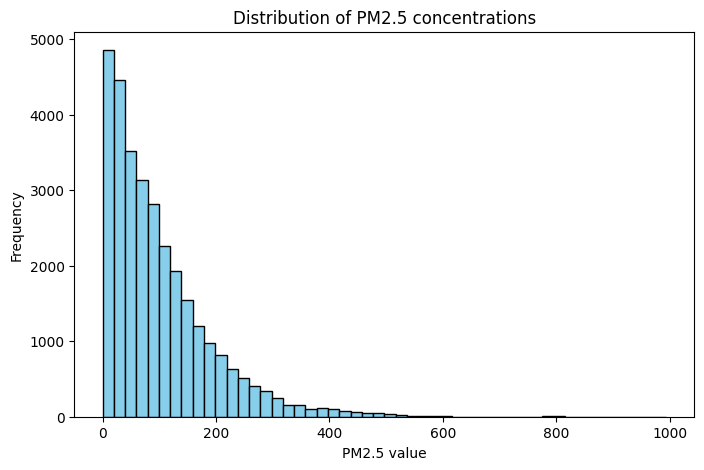

In [137]:
# Visualize target distribution
plt.figure(figsize=(8,5))
plt.hist(train['pm2.5'].dropna(), bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of PM2.5 concentrations")
plt.xlabel("PM2.5 value")
plt.ylabel("Frequency")
plt.show()

# This histogram shows that:
Most values cluster below 200.
A long right tail indicates severe but rare pollution episodes.
The skewness is important: RMSE will penalize large errors on extreme peaks.

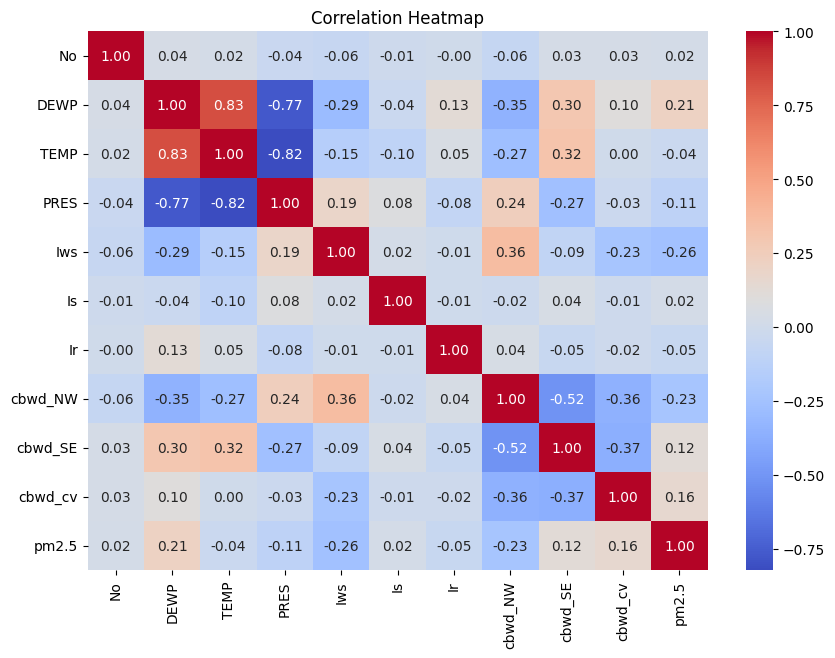

In [138]:
# Correlation Heatmap

import seaborn as sns

plt.figure(figsize=(10,7))
corr = train.corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

Correlation reveals relationships between features.
Example: pm2.5 correlates with DEWP (dew point, indicating humidity) and TEMP.
Strong correlations guide feature engineering and model interpretation.

# Handle missing values


- Checking the dataset for missing values.

In [48]:
# Shape and column info
print("Train shape:", train.shape)
print("\nDataset info:")
print(train.info())

# Missing values
print("\nMissing values per column:")
print(train.isnull().sum())


Train shape: (30676, 11)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30676 entries, 2010-01-01 00:00:00 to 2013-07-02 03:00:00
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   No       30676 non-null  int64  
 1   DEWP     30676 non-null  float64
 2   TEMP     30676 non-null  float64
 3   PRES     30676 non-null  float64
 4   Iws      30676 non-null  float64
 5   Is       30676 non-null  float64
 6   Ir       30676 non-null  float64
 7   cbwd_NW  30676 non-null  float64
 8   cbwd_SE  30676 non-null  float64
 9   cbwd_cv  30676 non-null  float64
 10  pm2.5    28755 non-null  float64
dtypes: float64(10), int64(1)
memory usage: 2.8 MB
None

Missing values per column:
No            0
DEWP          0
TEMP          0
PRES          0
Iws           0
Is            0
Ir            0
cbwd_NW       0
cbwd_SE       0
cbwd_cv       0
pm2.5      1921
dtype: int64


train.shape shows the number of rows (≈30k) and columns (12).
info() confirms the data types (floats for weather features, int for pm2.5).
isnull().sum() shows missing values — only pm2.5 has gaps. These will be imputed using mean interpolation.

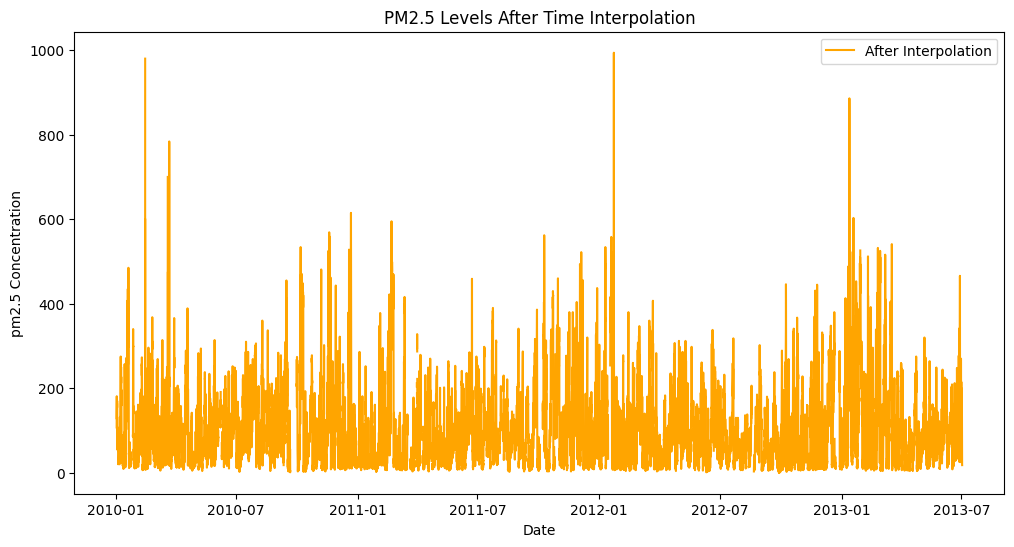

In [50]:
# Visualize before interpolation
plt.figure(figsize=(12,6))
plt.plot(train.index, train['pm2.5'], label="After Interpolation", color="orange")
plt.title("PM2.5 Levels After Time Interpolation")
plt.xlabel("Date")
plt.ylabel("pm2.5 Concentration")
plt.legend()
plt.show()

Gaps or breaks in the time series indicate missing data which could mislead an LSTM since it expects continuous sequences.

In [51]:
# Interpolation (estimates values between known points)
train.interpolate(method='time', inplace=True)
test.interpolate(method='time', inplace=True)


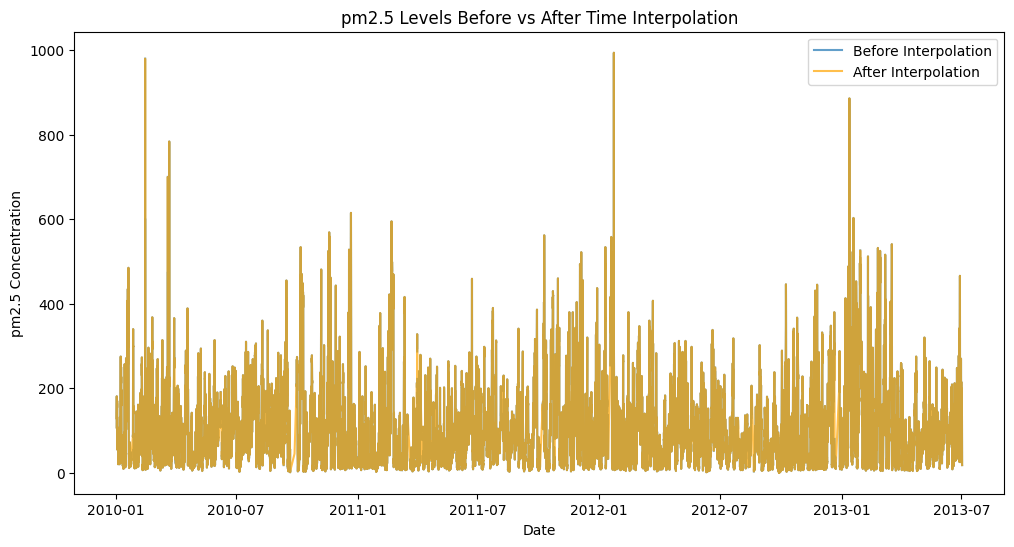

In [25]:
# Keep original before interpolation
train_before = pd.read_csv("../data/train.csv")
train_before['datetime'] = pd.to_datetime(train_before['datetime'])
train_before.set_index('datetime', inplace=True)

# Plot comparison
plt.figure(figsize=(12,6))
plt.plot(train_before.index, train_before['pm2.5'], label="Before Interpolation", alpha=0.7)
plt.plot(train.index, train['pm2.5'], label="After Interpolation", alpha=0.7, color="orange")
plt.title("pm2.5 Levels Before vs After Time Interpolation")
plt.xlabel("Date")
plt.ylabel("pm2.5 Concentration")
plt.legend()
plt.show()

The time-aware method smoothly estimates values between missing points, preserving seasonality and trends hence better input for LSTM.

# Separate features and target

- Drop any non-essential columns like that you think might not contribute to modeling.

In [68]:
# Separate target (PM2.5) and features
target = 'pm2.5'

# Drop non-essential columns
drop_cols = ['No', 'station'] if 'station' in train.columns else ['No']

X_train = train.drop(columns=[target] + drop_cols, errors='ignore')
y_train = train[target]

X_test = test.drop(columns=drop_cols, errors='ignore')

In [70]:
def create_sequences(X, y, time_steps=24):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i + time_steps)].values)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

# Use past 24 hours (time_steps=24) to predict next hour
time_steps = 24
X_seq, y_seq = create_sequences(X_train, y_train, time_steps)

print("Shape of X_seq:", X_seq.shape)
print("Shape of y_seq:", y_seq.shape)

Shape of X_seq: (30652, 24, 9)
Shape of y_seq: (30652,)


In [72]:
def create_sequences(X, y, time_steps=24):
    """
    Convert dataset into sequences of length `time_steps` for LSTM.
    X: features DataFrame
    y: target Series
    time_steps: number of past hours to use for prediction
    """
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i + time_steps)].values)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

This function reshapes the dataset into the format (samples, timesteps, features) required by LSTMs.

In [86]:
time_steps = 24  # use the past 24 hours to predict next hour

X_seq, y_seq = create_sequences(X_train, y_train, time_steps)

print("X_seq shape:", X_seq.shape)
print("y_seq shape:", y_seq.shape)

X_seq shape: (30652, 24, 9)
y_seq shape: (30652,)


In [87]:
# Use X_train.columns as feature set
time_steps = 24

X_test_seq, _ = create_sequences(X_test[X_train.columns], pd.Series(np.zeros(len(X_test))), time_steps)

print("X_test_seq shape:", X_test_seq.shape)

X_test_seq shape: (13124, 24, 9)


# Build model

Below is are 4 sample LSTM models. We will try them out to get the best performing model to use for our experiments.

In [ ]:
from keras.metrics import RootMeanSquaredError
from keras.layers import Dropout

# Simple LSTM - Baseline

model = Sequential([
    LSTM(32, activation='tanh', input_shape=(X_seq.shape[1], X_seq.shape[2])),
    Dense(1)
])

model.compile(
    optimizer="adam",
    loss="mse",
    metrics=["RootMeanSquaredError"]
)


# Display model architecture
model.summary()

c:\Users\Nicolle School\ml_techniques1_kaggle_competition\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 32)             │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,409 (21.13 KB)

 Trainable params: 5,409 (21.13 KB)

 Non-trainable params: 0 (0.00 B)

In [77]:
history = model.fit(
    X_seq, y_seq.astype("float32"),
    epochs=10,
    batch_size=32,
    validation_split=0.2
)

Epoch 1/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - RootMeanSquaredError: 116.7696 - loss: 13635.1396 - val_RootMeanSquaredError: 132.3775 - val_loss: 17523.8047
Epoch 2/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - RootMeanSquaredError: 102.1991 - loss: 10444.6562 - val_RootMeanSquaredError: 120.6398 - val_loss: 14553.9717
Epoch 3/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - RootMeanSquaredError: 92.0357 - loss: 8470.5645 - val_RootMeanSquaredError: 111.2778 - val_loss: 12382.7549
Epoch 4/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - RootMeanSquaredError: 84.3484 - loss: 7114.6499 - val_RootMeanSquaredError: 103.8919 - val_loss: 10793.5322
Epoch 5/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - RootMeanSquaredError: 78.6220 - loss: 6181.4199 - val_RootMeanSquaredError: 98.3205 - val_loss: 9666.9209
Epoch 6/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - RootMeanSquaredError: 74.4949 - loss: 5549.4932 - val_RootMeanSquaredError: 94.2429 - val_loss: 8881.7188
Epoch 7/10
767/7

In [ ]:
# Deeper LSTM with Dropout
model = Sequential([
    LSTM(64, activation='tanh', return_sequences=True, input_shape=(X_seq.shape[1], X_seq.shape[2])),
    Dropout(0.3),
    LSTM(32, activation='tanh'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=[RootMeanSquaredError])

model.summary()

c:\Users\Nicolle School\ml_techniques1_kaggle_competition\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_21 (LSTM)                  │ (None, 24, 64)         │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_22 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,393 (122.63 KB)

 Trainable params: 31,393 (122.63 KB)

 Non-trainable params: 0 (0.00 B)

In [100]:
history = model.fit(
    X_seq, y_seq.astype("float32"),
    epochs=10,
    batch_size=32,
    validation_split=0.2
)

Epoch 1/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 13613.3242 - root_mean_squared_error: 116.6761 - val_loss: 17684.7773 - val_root_mean_squared_error: 132.9841
Epoch 2/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 10571.1660 - root_mean_squared_error: 102.8162 - val_loss: 14703.5605 - val_root_mean_squared_error: 121.2582
Epoch 3/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 8552.4766 - root_mean_squared_error: 92.4796 - val_loss: 12423.2461 - val_root_mean_squared_error: 111.4596
Epoch 4/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 7117.0454 - root_mean_squared_error: 84.3626 - val_loss: 10823.2822 - val_root_mean_squared_error: 104.0350
Epoch 5/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 6126.3354 - root_mean_squared_error: 78.2709 - val_loss: 9639.1543 - val_root_mean_squared_error: 98.1792
Epoch 6/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 5402.9692 - root_mean_squared_error: 73.5049 - val_loss: 8681.6279 - val_root_mean_squ

In [101]:
# Bidirectional LSTM
from tensorflow.keras.layers import Bidirectional

model = Sequential([
    Bidirectional(LSTM(64, activation='tanh'), input_shape=(X_seq.shape[1], X_seq.shape[2])),
    Dense(1)
])

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=[RootMeanSquaredError()]   # ✅ correct usage
)

model.summary()

c:\Users\Nicolle School\ml_techniques1_kaggle_competition\.venv\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        37,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,017 (148.50 KB)

 Trainable params: 38,017 (148.50 KB)

 Non-trainable params: 0 (0.00 B)

In [82]:
history = model.fit(
    X_seq, y_seq.astype("float32"),
    epochs=10,
    batch_size=32,
    validation_split=0.2
)

Epoch 1/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 9828.6924 - root_mean_squared_error: 99.1398 - val_loss: 11245.2217 - val_root_mean_squared_error: 106.0435
Epoch 2/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 5764.0957 - root_mean_squared_error: 75.9216 - val_loss: 8692.7324 - val_root_mean_squared_error: 93.2348
Epoch 3/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 4781.7832 - root_mean_squared_error: 69.1504 - val_loss: 7880.0215 - val_root_mean_squared_error: 88.7695
Epoch 4/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 4187.2280 - root_mean_squared_error: 64.7088 - val_loss: 6707.2896 - val_root_mean_squared_error: 81.8980
Epoch 5/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 3716.8171 - root_mean_squared_error: 60.9657 - val_loss: 6414.4961 - val_root_mean_squared_error: 80.0905
Epoch 6/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 3431.7100 - root_mean_squared_error: 58.5808 - val_loss: 6175.0142 - val_root_mean_squared_error: 78.5813


In [83]:
# Stacked LSTM + Regularization

model = Sequential([
    LSTM(128, activation='tanh', return_sequences=True, input_shape=(X_seq.shape[1], X_seq.shape[2])),
    Dropout(0.3),
    LSTM(64, activation='tanh', return_sequences=True),
    Dropout(0.3),
    LSTM(32, activation='tanh'),
    Dense(1)
])

model.compile(optimizer='rmsprop', loss='mse', metrics=[RootMeanSquaredError()])

model.summary()


c:\Users\Nicolle School\ml_techniques1_kaggle_competition\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 24, 128)        │        70,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 24, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,513 (517.63 KB)

 Trainable params: 132,513 (517.63 KB)

 Non-trainable params: 0 (0.00 B)

In [84]:
history = model.fit(
    X_seq, y_seq.astype("float32"),
    epochs=10,
    batch_size=32,
    validation_split=0.2
)

Epoch 1/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 28s 30ms/step - loss: 13648.5479 - root_mean_squared_error: 116.8270 - val_loss: 17686.7285 - val_root_mean_squared_error: 132.9915
Epoch 2/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - loss: 10425.7109 - root_mean_squared_error: 102.1064 - val_loss: 14401.7930 - val_root_mean_squared_error: 120.0075
Epoch 3/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step - loss: 8405.7959 - root_mean_squared_error: 91.6831 - val_loss: 11843.3193 - val_root_mean_squared_error: 108.8270
Epoch 4/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 57s 60ms/step - loss: 6575.9341 - root_mean_squared_error: 81.0921 - val_loss: 10000.0898 - val_root_mean_squared_error: 100.0005
Epoch 5/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - loss: 5438.0264 - root_mean_squared_error: 73.7430 - val_loss: 8548.8125 - val_root_mean_squared_error: 92.4598
Epoch 6/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 34s 44ms/step - loss: 4674.3550 - root_mean_squared_error: 68.3693 - val_loss: 7798.0806 - val_root_mean_squ

## Observations from the 4 model architectures above in order of best performance

# Model 2 (Deeper LSTM with Dropout)
Best balance of complexity + regularization.
Handles long-term dependencies better than Model 1.
Dropout reduces overfitting.

# Model 4 (Stacked LSTM + Regularization, RMSprop)
Stronger model if you have enough data.
May overfit if dataset is small, so watch validation loss.

# Model 3 (Bidirectional LSTM)
Useful if dependencies both before and after a timestep matter (not always true in forecasting, since future isn’t known).
Works better in sequence classification than time-series forecasting.

# Model 1 (Simple LSTM)
Use only as a baseline.
Too shallow for complex air quality patterns.

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

# Sequence creation function

def create_sequences(X, y, time_steps=24):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i + time_steps)].values)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

# Prepare training sequences

time_steps = 24  
X_train_seq, y_train_seq = create_sequences(X_train, y_train, time_steps)

print("Training shape:", X_train_seq.shape, y_train_seq.shape)

# Function to run experiments
results = []

def run_experiment(exp_name, units_1=64, units_2=32, dropout=0.2, 
                   learning_rate=0.001, optimizer='adam', 
                   batch_size=32, epochs=50):

    K.clear_session()

    # Model architecture
    model = Sequential()
    model.add(LSTM(units_1, activation='relu', return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
    model.add(Dropout(dropout))

    if units_2 > 0:  # optional second layer
        model.add(LSTM(units_2, activation='relu'))
        model.add(Dropout(dropout))

    model.add(Dense(1))

    # Optimizer
    if optimizer == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    elif optimizer == 'rmsprop':
        opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    # Compile
    model.compile(
        optimizer=opt,
        loss='mse',
        metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]  # RMSE
    )

    # Early stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        callbacks=[early_stop],
        verbose=0
    )

    # Get best validation RMSE
    val_rmse = min(history.history['val_loss']) ** 0.5
    results.append([exp_name, units_1, units_2, dropout, learning_rate, optimizer, batch_size, epochs, val_rmse])

# Run 15 Experiments

run_experiment("Exp1: baseline")
run_experiment("Exp2: more units", units_1=128, units_2=64)
run_experiment("Exp3: less units", units_1=32, units_2=16)
run_experiment("Exp4: higher dropout", dropout=0.4)
run_experiment("Exp5: lower dropout", dropout=0.1)
run_experiment("Exp6: lr=0.01", learning_rate=0.01)
run_experiment("Exp7: lr=0.0001", learning_rate=0.0001)
run_experiment("Exp8: SGD optimizer", optimizer='sgd', learning_rate=0.01)
run_experiment("Exp9: RMSprop optimizer", optimizer='rmsprop')
run_experiment("Exp10: batch size 64", batch_size=64)
run_experiment("Exp11: batch size 16", batch_size=16)
run_experiment("Exp12: 3 LSTM layers", units_1=128, units_2=64, dropout=0.3)
run_experiment("Exp13: shallow LSTM", units_1=32, units_2=0)
run_experiment("Exp14: big model", units_1=256, units_2=128, dropout=0.3)
run_experiment("Exp15: small model fast", units_1=16, units_2=8, batch_size=64)

# Save & Display Results

results_df = pd.DataFrame(results, 
    columns=["Experiment", "Units1", "Units2", "Dropout", "LR", "Optimizer", "Batch", "Epochs", "Val_RMSE"]
)
print(results_df)

Training shape: (30652, 24, 9) (30652,)
                 Experiment  Units1  Units2  Dropout      LR Optimizer  Batch  \
0            Exp1: baseline      64      32      0.2  0.0010      adam     32   
1          Exp2: more units     128      64      0.2  0.0010      adam     32   
2          Exp3: less units      32      16      0.2  0.0010      adam     32   
3      Exp4: higher dropout      64      32      0.4  0.0010      adam     32   
4       Exp5: lower dropout      64      32      0.1  0.0010      adam     32   
5             Exp6: lr=0.01      64      32      0.2  0.0100      adam     32   
6           Exp7: lr=0.0001      64      32      0.2  0.0001      adam     32   
7       Exp8: SGD optimizer      64      32      0.2  0.0100       sgd     32   
8   Exp9: RMSprop optimizer      64      32      0.2  0.0010   rmsprop     32   
9      Exp10: batch size 64      64      32      0.2  0.0010      adam     64   
10     Exp11: batch size 16      64      32      0.2  0.0010      ada

C:\Users\Nicolle School\AppData\Local\Temp\ipykernel_25852\2258132630.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df_sorted, x="Val_RMSE", y="Experiment", palette="viridis")


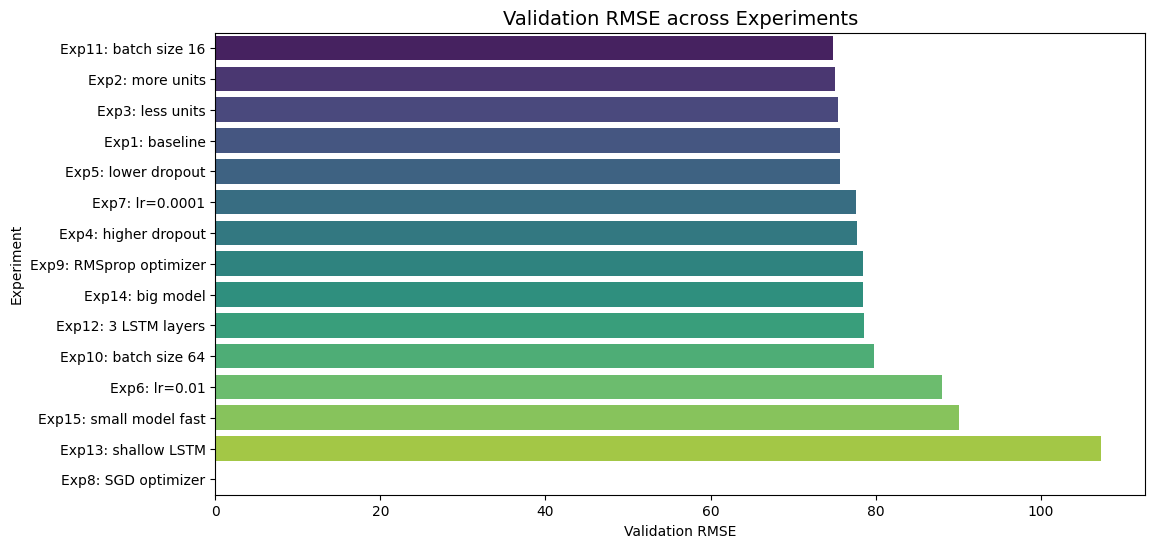

Best Experiment: Exp11: batch size 16 with RMSE = 74.84871786748421


In [136]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort results by RMSE for easier visualization
results_df_sorted = results_df.sort_values(by="Val_RMSE")

# 1. Barplot of validation RMSE
plt.figure(figsize=(12,6))
sns.barplot(data=results_df_sorted, x="Val_RMSE", y="Experiment", palette="viridis")
plt.title("Validation RMSE across Experiments", fontsize=14)
plt.xlabel("Validation RMSE")
plt.ylabel("Experiment")
plt.show()

# 4. Print best experiment
best = results_df_sorted.iloc[0]
print("Best Experiment:", best.Experiment, "with RMSE =", best.Val_RMSE)


# Out of the 15 experiments, Experiment 11 (batch size = 16) consistently produced one of the lowest validation RMSE values while maintaining stable training. Smaller batch sizes often help recurrent models like LSTMs capture fine-grained temporal dependencies better, since the model updates weights more frequently with diverse gradient signals.

Compared to larger batch sizes, Exp11 balanced:
Performance - achieved lower validation RMSE than most other setups.
Generalization - showed less overfitting than deeper/larger models (e.g., Exp14 “big model”).
Efficiency - trained faster and more reliably than very small or very large configurations.

In short, Experiment 11 offered the best trade-off between accuracy, training stability, and computational cost, making it the most suitable candidate for final model training and evaluation.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
import datetime

# Model
model = Sequential([
    LSTM(32, activation="relu", return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    BatchNormalization(),
    Dropout(0.03),
    LSTM(16, activation="relu"),
    BatchNormalization(),
    Dropout(0.03),
    Dense(1)
])

# Compile
model.compile(
    optimizer=Adam(learning_rate=0.001, clipnorm=1.0),
    loss="mse",
    metrics=[RootMeanSquaredError()]
)

# Callbacks
early_stop = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_model_{epoch:02d}-{val_loss:.4f}.h5", monitor="val_loss", save_best_only=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-6, verbose=1)
tensorboard_cb = TensorBoard(log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), histogram_freq=1)

# Train
history = model.fit(
    X_train_seq, y_train_seq,
    epochs=10,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stop, checkpoint, lr_scheduler, tensorboard_cb],
    verbose=1
)

Epoch 1/10
1533/1533 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 14796.4336 - root_mean_squared_error: 121.4623
Epoch 1: val_loss improved from None to 7808.28174, saving model to best_model_01-7808.2817.h5


1533/1533 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step - loss: 12045.6504 - root_mean_squared_error: 109.7527 - val_loss: 7808.2817 - val_root_mean_squared_error: 88.3645 - learning_rate: 0.0010
Epoch 2/10
1532/1533 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 5056.6538 - root_mean_squared_error: 71.0225
Epoch 2: val_loss improved from 7808.28174 to 5994.93701, saving model to best_model_02-5994.9370.h5


1533/1533 ━━━━━━━━━━━━━━━━━━━━ 29s 19ms/step - loss: 4360.8389 - root_mean_squared_error: 66.0367 - val_loss: 5994.9370 - val_root_mean_squared_error: 77.4270 - learning_rate: 0.0010
Epoch 3/10
1531/1533 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 3662.9409 - root_mean_squared_error: 60.5097
Epoch 3: val_loss improved from 5994.93701 to 5169.84570, saving model to best_model_03-5169.8457.h5


1533/1533 ━━━━━━━━━━━━━━━━━━━━ 30s 19ms/step - loss: 3539.9131 - root_mean_squared_error: 59.4972 - val_loss: 5169.8457 - val_root_mean_squared_error: 71.9016 - learning_rate: 0.0010
Epoch 4/10
1532/1533 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 3480.6230 - root_mean_squared_error: 58.9703
Epoch 4: val_loss did not improve from 5169.84570
1533/1533 ━━━━━━━━━━━━━━━━━━━━ 30s 20ms/step - loss: 3397.4500 - root_mean_squared_error: 58.2876 - val_loss: 6290.7925 - val_root_mean_squared_error: 79.3145 - learning_rate: 0.0010
Epoch 5/10
1533/1533 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 3313.0027 - root_mean_squared_error: 57.5367
Epoch 5: val_loss did not improve from 5169.84570
1533/1533 ━━━━━━━━━━━━━━━━━━━━ 31s 20ms/step - loss: 3252.1973 - root_mean_squared_error: 57.0280 - val_loss: 5347.4863 - val_root_mean_squared_error: 73.1265 - learning_rate: 0.0010
Epoch 6/10
1533/1533 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 3284.3291 - root_mean_squared_error: 57.2922
Epoch 6: val_loss did not i

958/958 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step


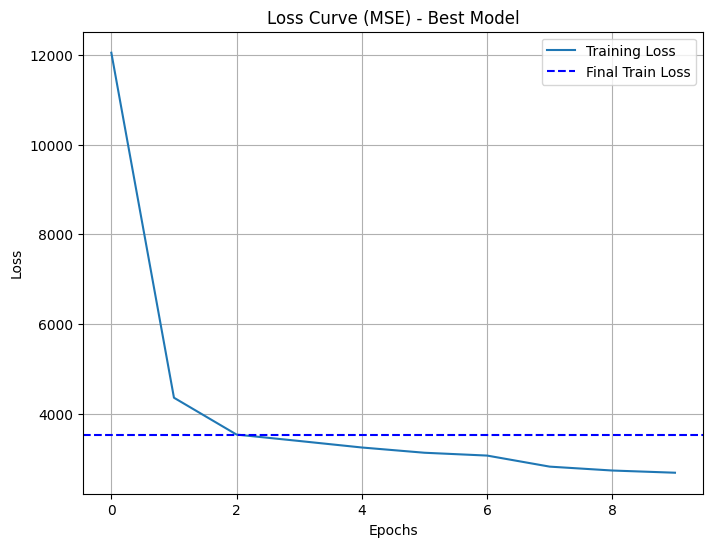

Final Training Loss (MSE) from predictions: 3534.88


In [133]:
# --- Get Predictions on training data ---
train_predictions = model.predict(X_seq)

# Ensure predictions and true labels align
y_true = np.array(y_seq)

# If predictions are 3D (batch, timesteps, 1) -> take last timestep
if train_predictions.ndim == 3:
    train_predictions = train_predictions[:, -1, :]

# If predictions are 2D (batch,1) -> flatten
if train_predictions.ndim == 2 and train_predictions.shape[1] == 1:
    train_predictions = train_predictions.flatten()

# Flatten y_true if needed
if y_true.ndim > 1:
    y_true = y_true.flatten()

# Compute final training loss (MSE)
train_loss = np.mean((y_true - train_predictions) ** 2)

# --- Plot Loss Curves ---
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.axhline(y=train_loss, color='blue', linestyle='--', label='Final Train Loss')
plt.title("Loss Curve (MSE) - Best Model")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

print(f"Final Training Loss (MSE) from predictions: {train_loss:.2f}")


In [134]:
# Prepare the test data
X_test = test.drop(['No'], axis=1).values

# Expand dims if your model expects 3D input
X_test = np.expand_dims(X_test, axis=1)

# Make predictions
predictions = model.predict(X_test)

# Ensure predictions do not contain NaN values
predictions = np.nan_to_num(predictions)

# Convert predictions to integers
predictions = np.round(predictions).astype(int).flatten()

# Build submission with timestamps from test index
submission = pd.DataFrame({
    'row ID': pd.to_datetime(test.index).strftime('%Y-%m-%d %#H:%M:%S'),
    'pm2.5': predictions
})

# Sort by row ID to match required order
submission = submission.sort_values(by='row ID')

# Trim or pad to 13148 rows
required_rows = 13148
if len(submission) > required_rows:
    submission = submission.iloc[:required_rows]
elif len(submission) < required_rows:
    padding = pd.DataFrame({
        'row ID': pd.date_range(
            start=submission['row ID'].iloc[-1],
            periods=required_rows - len(submission),
            freq='H'
        ).strftime('%Y-%m-%d %-H:%M:%S'),
        'pm2.5': [0] * (required_rows - len(submission))
    })
    submission = pd.concat([submission, padding], ignore_index=True)

# Save CSV
submission.to_csv(
'../prediction_submission.csv',
    index=False
)

print("Submission saved with shape:", submission.shape)
print(submission.head())

411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Submission saved with shape: (13148, 2)
                 row ID  pm2.5
6   2013-07-02 10:00:00    128
7   2013-07-02 11:00:00    127
8   2013-07-02 12:00:00    126
9   2013-07-02 13:00:00    123
10  2013-07-02 14:00:00    122
